# Simple audio recognition: Recognizing keywords

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
import utils
from utils.audio_utils import *
from utils.audio_models import *

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


## Speech dataset (2.11 GB uncompressed)
#### http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

# Speech dataset (2.11 GB uncompressed)
# http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# if not data_dir.exists():
#     tf.keras.utils.get_file(
#     'mini_speech_commands.zip',
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
#     extract=True,
#     cache_dir='.', cache_subdir='data')

# Experiment with different audio features

#### MFCC • A highly engineered preprocessing of the audio waveform

MFCC computation involves 6 steps

1. Segment the signal into short frames
2. For each frame: calculate its power spectrum
3. Apply a Mel filterbank to the power spectrum
    • sum the energy within each filter.
    

    We take clumps of periodogram bins and sum them up to get an
    idea of how much energy there exists in each region
    • This is performed using a Mel filterbank
    • First Mel filter is very narrow: to get an idea of how much energy there
    is around 0 Hertz
    • Filters get wider as frequencies get higher: we become less
    concerned about variations (Mel scale tells us how to space filterbanks)
4. Take the logarithm of all filterbank energies
5. Take the DCT of the log filterbank energies - DCT decorrelates filterbank energies
6. Keep DCT coefficients 2-13, discard the others

## File signal example and feature vector calculation

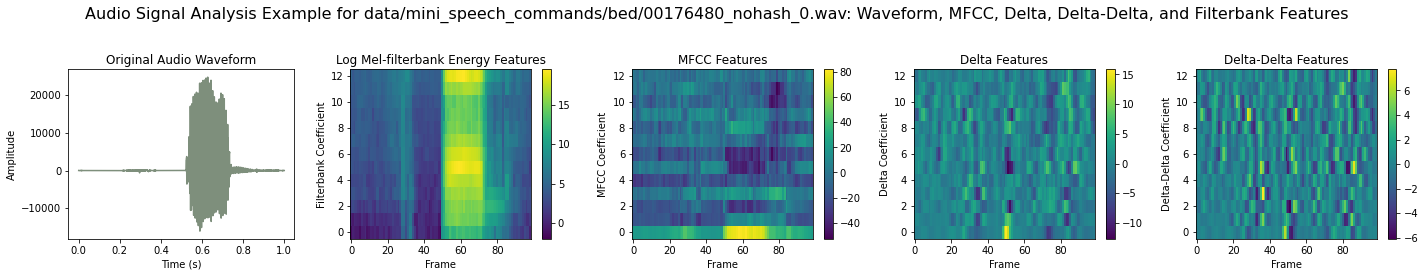

In [3]:
# Load an example audio file for inference
data_dir = 'data/mini_speech_commands/bed/'
file = '00176480_nohash_0.wav'
file_path = os.path.join(data_dir, file)
rate, example_signal = wavfile.read(file_path)

sig_ds, rate_ds, feature_dicts = example_feature_vectors(file_path, 1)

# Separate dictionaries for each feature type
signal_dict = feature_dicts['signal_dict']
mfcc_dict = feature_dicts['mfcc_dict']
delta_dict = feature_dicts['delta_dict']
delta_delta_dict = feature_dicts['delta_delta_dict']
fbank_dict = feature_dicts['fbank_dict']
full_feature_vector_dict = feature_dicts['full_feature_vector_dict']

plot_example(sig_ds, rate_ds, fbank_dict, mfcc_dict, delta_dict, delta_delta_dict, file_path)

## Calculate the feature vectors of words

In [4]:
# # Path to the directory containing folders with .wav files
# data_dir = 'data/mini_speech_commands'

# # Get a list of folders in the directory
# words = os.listdir(data_dir)

# # Calculate the feature vector
# signal_ds, spectro_ds, mfcc_ds, delta_ds, delta_delta_ds, full_feature_vector_ds = calculate_feature_vector(data_dir, words, num_words=5)

# # Create the 'feature_data' directory if it doesn't exist
# feature_data_dir = 'feature_data'
# os.makedirs(feature_data_dir, exist_ok=True)

# # Save the feature vectors in the 'feature_data' folder
# save_path = os.path.join(feature_data_dir, 'ten_words.pkl')
# with open(save_path, 'wb') as file:
#     pickle.dump((signal_ds, spectro_ds, mfcc_ds, delta_ds, delta_delta_ds, full_feature_vector_ds), file)

## Import Datasets

In [5]:
# Load the feature vectors from the saved pickle file
load_path = 'feature_data/ten_words.pkl'
with open(load_path, 'rb') as file:
    signal_ds, spectro_ds, mfcc_ds, delta_ds, delta_delta_ds, full_feature_vector_ds = pickle.load(file)


In [6]:
# Convert each dictionary value from list to array
convert_to_arrays(signal_ds)
convert_to_arrays(spectro_ds)
convert_to_arrays(mfcc_ds)
convert_to_arrays(delta_ds)
convert_to_arrays(delta_delta_ds)
convert_to_arrays(full_feature_vector_ds)

# Add channel axis, N, 99, 13, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(signal_ds)
add_new_axis(spectro_ds)
add_new_axis(mfcc_ds)
add_new_axis(delta_ds)
add_new_axis(delta_delta_ds)
# Add channel axis, N, 99, 43, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(full_feature_vector_ds)

In [8]:
n_classes = 9
epochs = 30

## Feature Vector: Regular Spectrogram

In [10]:
# Split in train and test
X_train, X_test, y_train, y_test, sig_train, sig_test, one_hot_labels, one_hot_encoder, y_decoded_train, y_decoded_test = train_test_creation(spectro_ds, signal_ds)

# Perform data augmentation
X_train_augmented = augment_data(X_train, augmentation_percentage=0.2)

# Normalize the data, cache it and batch it
train_dataset, test_dataset, img_shape = normalize_cache_batch(X_train_augmented, X_test, y_train, y_test, cache_batch=True)

# Analyze example audio file from X_train

In [11]:
import numpy as np
import sounddevice as sd

# Assuming audio_array is an array of dtype=object containing audio data
audio_array = sig_train[2]  # Replace sig_train[2] with your audio data

# Convert audio_array to a numpy array of type int16
audio_array = np.array(audio_array[0], dtype=np.int16)

# Play audio
sd.play(audio_array, samplerate=16000)
sd.wait()  # Wait until playback is finished

Y_pred_decoded_labels_inc = one_hot_encoder.inverse_transform(y_train[2].reshape(1, -1))

print("OneHotEncoded:", y_train[2])
print("Decoded:", Y_pred_decoded_labels_inc)

OneHotEncoded: [0. 0. 0. 0. 0. 0. 0. 1. 0.]
Decoded: [['right']]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 5, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 3, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 64)                9

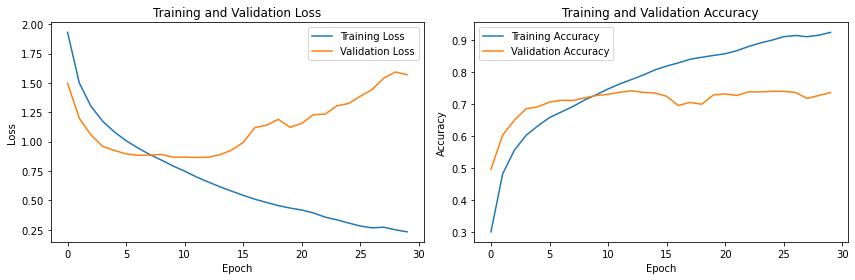

45/45 [==============================] - 0s 5ms/step - loss: 1.5705 - accuracy: 0.7358
Test Loss: 1.5705
Test Accuracy: 0.7358
45/45 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    backward       0.89      0.84      0.86       304
         bed       0.62      0.61      0.62       297
         cat       0.81      0.69      0.74       301
       eight       0.81      0.75      0.78       337
          go       0.65      0.57      0.61       326
       happy       0.88      0.86      0.87       304
       learn       0.66      0.76      0.70       316
       right       0.64      0.67      0.65       313
        tree       0.71      0.87      0.78       337

    accuracy                           0.74      2835
   macro avg       0.74      0.74      0.74      2835
weighted avg       0.74      0.74      0.74      2835



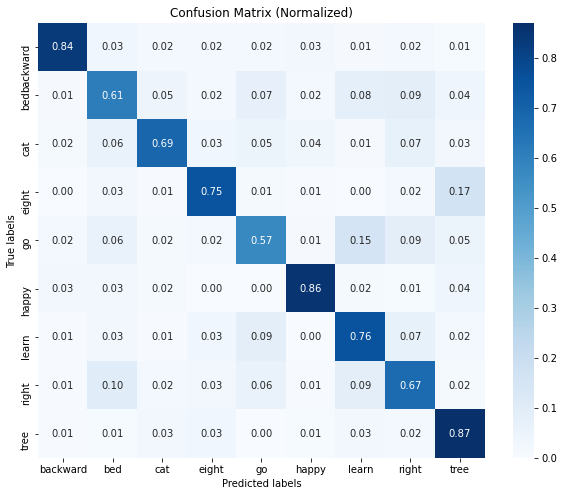

Memory Allocation: 1437.34 MB
Memory Usage: 71.00


In [12]:
# Train and Evaluate
model_spectro = CNN_model_simple_batch(train_dataset, test_dataset, one_hot_encoder, num_classes=n_classes, N_Epochs=epochs, inp_shape=img_shape)


# Experiment with different audio features

## Feature Vector: with only MFCC

In [13]:
# Split in train and test
X_train, X_test, y_train, y_test, sig_train, sig_test, one_hot_labels, one_hot_encoder, y_decoded_train, y_decoded_test = train_test_creation(mfcc_ds, signal_ds)

# Perform data augmentation
X_train_augmented = augment_data(X_train, augmentation_percentage=0.2)

# Normalize the data, cache it and batch it
train_dataset, test_dataset, img_shape = normalize_cache_batch(X_train_augmented, X_test, y_train, y_test, cache_batch=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 97, 11, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 3, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1472)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

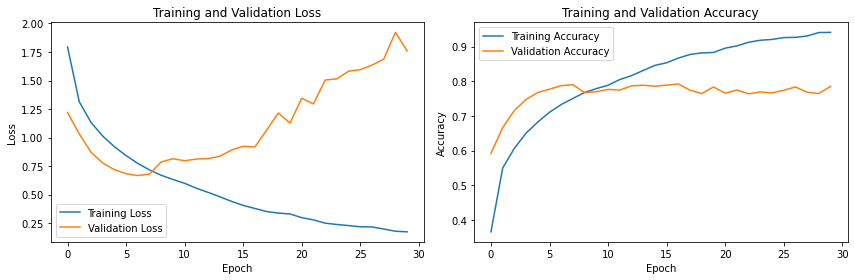

45/45 [==============================] - 0s 5ms/step - loss: 1.7595 - accuracy: 0.7855
Test Loss: 1.7595
Test Accuracy: 0.7855
45/45 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    backward       0.83      0.72      0.77       324
         bed       0.73      0.77      0.75       331
         cat       0.65      0.90      0.76       330
       eight       0.82      0.87      0.84       320
          go       0.89      0.67      0.76       323
       happy       0.80      0.83      0.82       300
       learn       0.77      0.74      0.75       306
       right       0.77      0.75      0.76       292
        tree       0.90      0.83      0.86       309

    accuracy                           0.79      2835
   macro avg       0.80      0.79      0.79      2835
weighted avg       0.80      0.79      0.79      2835



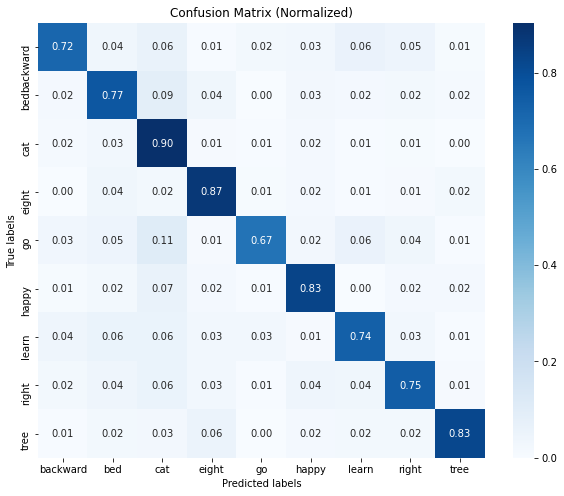

Memory Allocation: 1877.38 MB
Memory Usage: 71.60


In [14]:
# Train and Evaluate
model_mfcc = CNN_model_simple_batch(train_dataset, test_dataset, one_hot_encoder, num_classes=n_classes, N_Epochs=epochs, inp_shape=img_shape)


## Full Feature Vector: with MFCC, Delta and Delta-Delta, Delta/DD/E coeff

In [15]:
# Split in train and test
X_train, X_test, y_train, y_test, sig_train, sig_test, one_hot_labels, one_hot_encoder, y_decoded_train, y_decoded_test = train_test_creation(full_feature_vector_ds, signal_ds)

# Perform data augmentation
X_train_augmented = augment_data(X_train, augmentation_percentage=0.2)

# Normalize the data, cache it and batch it
train_dataset, test_dataset, img_shape = normalize_cache_batch(X_train_augmented, X_test, y_train, y_test, cache_batch=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 97, 41, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 20, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 18, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 9, 64)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 13248)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

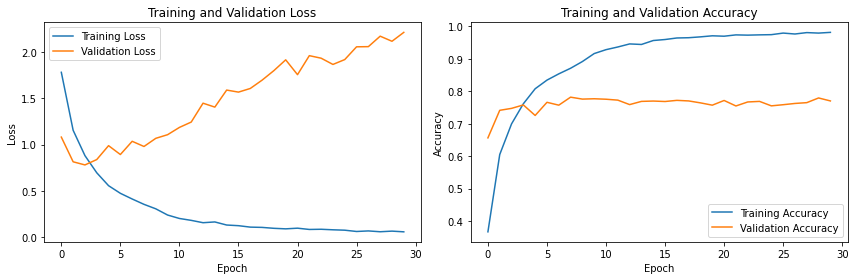

45/45 [==============================] - 2s 37ms/step - loss: 2.2141 - accuracy: 0.7704
Test Loss: 2.2141
Test Accuracy: 0.7704
45/45 [==============================] - 2s 38ms/step
Classification Report:
              precision    recall  f1-score   support

    backward       0.84      0.73      0.78       313
         bed       0.79      0.70      0.74       311
         cat       0.78      0.71      0.74       329
       eight       0.79      0.78      0.79       319
          go       0.74      0.81      0.78       296
       happy       0.73      0.80      0.76       316
       learn       0.74      0.73      0.73       316
       right       0.66      0.84      0.74       294
        tree       0.90      0.83      0.86       341

    accuracy                           0.77      2835
   macro avg       0.77      0.77      0.77      2835
weighted avg       0.78      0.77      0.77      2835



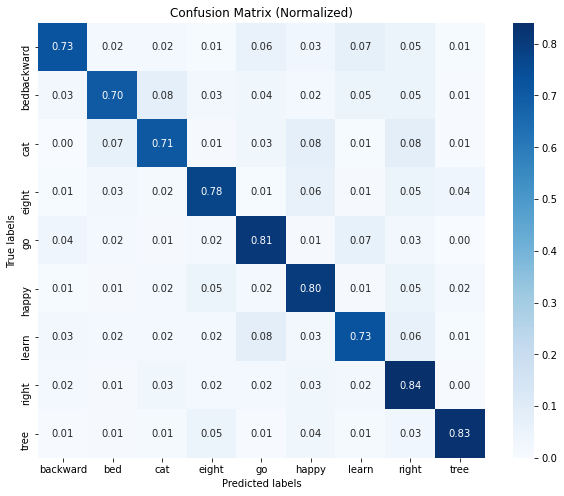

Memory Allocation: 3272.26 MB
Memory Usage: 64.60


In [16]:
# Train and Evaluate
model_full_v = CNN_model_simple_batch(train_dataset, test_dataset, one_hot_encoder, num_classes=n_classes, N_Epochs=epochs, inp_shape=img_shape)


# Play with a standard/deep CNN using

#### dropout, regularization

In [17]:
# Split in train and test
X_train, X_test, y_train, y_test, sig_train, sig_test, one_hot_labels, one_hot_encoder, y_decoded_train, y_decoded_test = train_test_creation(mfcc_ds, signal_ds)

# Perform data augmentation
X_train_augmented = augment_data(X_train, augmentation_percentage=0.2)

# Normalize the data, cache it and batch it
train_dataset, test_dataset, img_shape = normalize_cache_batch(X_train_augmented, X_test, y_train, y_test, cache_batch=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 97, 11, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 5, 32)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 48, 5, 32)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 3, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 1, 64)        

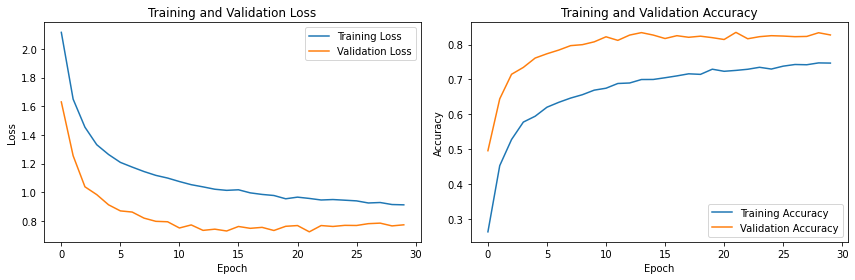

45/45 [==============================] - 0s 5ms/step - loss: 0.7722 - accuracy: 0.8279
Test Loss: 0.7722
Test Accuracy: 0.8279
45/45 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    backward       0.91      0.78      0.84       323
         bed       0.62      0.84      0.72       308
         cat       0.86      0.81      0.83       308
       eight       0.78      0.87      0.82       301
          go       0.84      0.81      0.82       311
       happy       0.88      0.84      0.86       301
       learn       0.86      0.79      0.82       320
       right       0.94      0.84      0.88       346
        tree       0.86      0.88      0.87       317

    accuracy                           0.83      2835
   macro avg       0.84      0.83      0.83      2835
weighted avg       0.84      0.83      0.83      2835



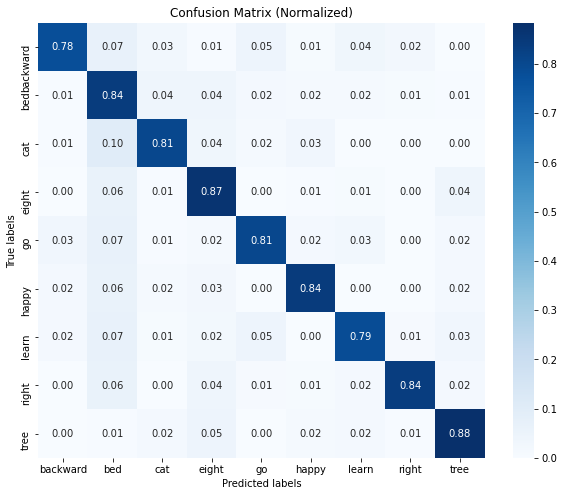

Memory Allocation: 3579.54 MB
Memory Usage: 62.00


In [18]:
# Call the updated function
model_drop_reg = CNN_model_with_dropout_batch(train_dataset, test_dataset, one_hot_encoder, 
                                     num_classes=n_classes, N_Epochs=epochs, 
                                     inp_shape=img_shape, dropout_rate=0.2, 
                                     l2_regularization=0.001, learning_rate=0.001)

## Grid Search for l2_regularization and dropout_rate hyperparameters

In [ ]:
import numpy as np
from sklearn.model_selection import ParameterGrid

# Define the grid of hyperparameters
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'l2_regularization': [0.0001, 0.001]
}

# Initialize variables to store best hyperparameters and corresponding accuracy
best_params = None
best_accuracy = 0.0

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    dropout_rate = params['dropout_rate']
    l2_regularization = params['l2_regularization']
    
    # Call the updated function with current hyperparameters
    model = CNN_model_with_dropout_batch(train_dataset, test_dataset, one_hot_encoder, 
                                         num_classes=n_classes, N_Epochs=epochs, 
                                         inp_shape=img_shape, dropout_rate=dropout_rate, 
                                         l2_regularization=l2_regularization, learning_rate=0.001)
    
    # Train the model
    # Assuming train_dataset contains training data
    # You need to implement the training process inside CNN_model_with_dropout_batch
    
    # Evaluate the model on test dataset
    # Assuming test_dataset is a TensorFlow dataset object containing input data and labels
    evaluation_metrics = model.evaluate(test_dataset)

    # Extract the accuracy from the evaluation metrics
    accuracy = evaluation_metrics[1]  # Assuming accuracy is the second metric in the list

    # Update best hyperparameters if current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best hyperparameters:", best_params)
print("Best accuracy:", best_accuracy)

# Run best model with droput and l2 reg

In [11]:
epochs = 30

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 5, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 5, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 3, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 1, 64)         0

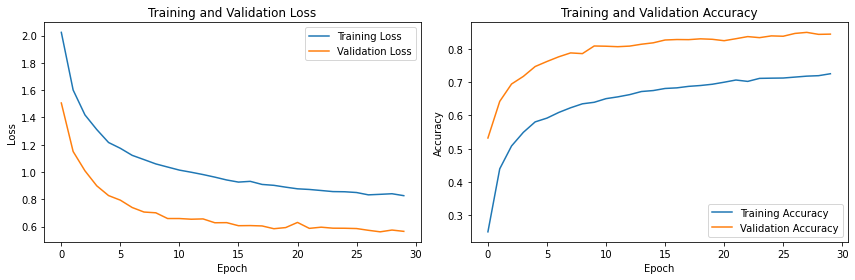

45/45 [==============================] - 0s 4ms/step - loss: 0.5657 - accuracy: 0.8444
Test Loss: 0.5657
Test Accuracy: 0.8444
45/45 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

    backward       0.87      0.83      0.85       329
         bed       0.73      0.83      0.78       327
         cat       0.81      0.83      0.82       301
       eight       0.90      0.88      0.89       295
          go       0.81      0.81      0.81       349
       happy       0.85      0.88      0.86       289
       learn       0.82      0.87      0.85       331
       right       0.94      0.80      0.87       317
        tree       0.92      0.88      0.90       297

    accuracy                           0.84      2835
   macro avg       0.85      0.85      0.85      2835
weighted avg       0.85      0.84      0.85      2835



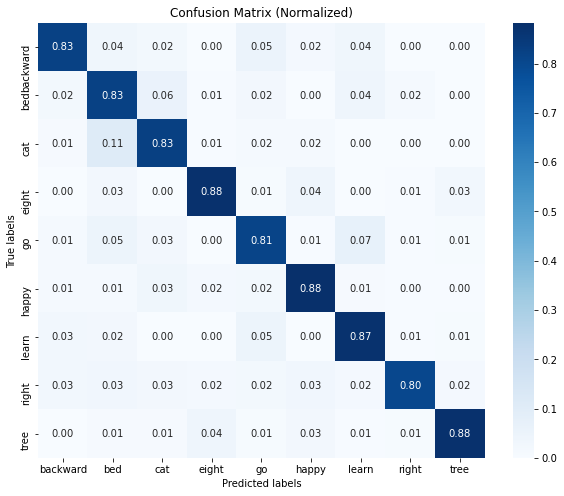

Memory Allocation: 412.03 MB
Memory Usage: 60.60


In [12]:
# Call the updated function
model_best = CNN_model_with_dropout_batch(train_dataset, test_dataset, one_hot_encoder, 
                                     num_classes=n_classes, N_Epochs=epochs, 
                                     inp_shape=img_shape, dropout_rate=0.3, 
                                     l2_regularization=0.0001, learning_rate=0.001)

## Save Model

In [13]:
# Save the trained model in the recommended format
model_best.save('models/cnn/CNN_drop_l2.keras')

# Save the label encoder
joblib.dump(one_hot_encoder, 'models/cnn/label_encoder_cnn.pkl')

['models/cnn/label_encoder_cnn.pkl']